<h1>ROCKS CHALLENGE: Image Classification (Resnet50)</h1>

<h2>1) Import all dependencies</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json

 <h2>2) Import data</h2>

In [2]:
train_dir = './data/train'
val_dir   = './data/val'
test_dir  = './data/test'

In [3]:
#Load Train data
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='binary',
    target_size=(160,160))

#Load Validation data
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    shuffle=False,
    class_mode='sparse',
    target_size=(160,160))

#Load Test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    class_mode='sparse',
    target_size=(160,160))

Found 6813 images belonging to 4 classes.
Found 847 images belonging to 4 classes.
Found 850 images belonging to 4 classes.


<h2>3) Load ResNet50 Model</h2>


In [4]:
conv_base = ResNet50(input_shape=(160,160,3),
                    include_top=False, 
                    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

<h2>4) Set fully connected layer</h2>

In [5]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(4, activation='softmax')(x)
model = Model(conv_base.input, predictions)

<h2>5) Set training parameters</h2>


In [6]:
optimizer = keras.optimizers.RMSprop(learning_rate=1e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./models/resnet50_.{epoch:02d}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [7]:
tf.debugging.set_log_device_placement(True)
try:
    with tf.device('/device:GPU:0'):
        history = model.fit(
                              train_generator,
                              epochs=20,
                              validation_data=validation_generator,
                              callbacks = callbacks
                             )
except RuntimeError as e:
    print(e)

C:\Users\mat\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
213/213 [==============================] - 343s 2s/step - loss: 0.8972 - accuracy: 0.6297 - val_loss: 0.4376 - val_accuracy: 0.8394
Epoch 2/20
213/213 [==============================] - 98s 460ms/step - loss: 0.3596 - accuracy: 0.8607 - val_loss: 0.2898 - val_accuracy: 0.8819
Epoch 3/20
213/213 [==============================] - 120s 560ms/step - loss: 0.2818 - accuracy: 0.8852 - val_loss: 0.2557 - val_accuracy: 0.8961
Epoch 4/20
213/213 [==============================] - 124s 584ms/step - loss: 0.2542 - accuracy: 0.8939 - val_loss: 0.2419 - val_accuracy: 0.8961
Epoch 5/20
213/213 [==============================] - 124s 584ms/step - loss: 0.2353 - accuracy: 0.9009 - val_loss: 0.2343 - val_accuracy: 0.8973
Epoch 6/20
213/213 [==============================] - 126s 594ms/step - loss: 0.2259 - accuracy: 0.9075 - val_loss: 0.2286 - val_accuracy: 0.8985
Epoch 7/20
213/213 [==============================] - 116s 546ms/step - loss: 0.2200 - accuracy: 0.9083 - val_loss: 0.2261 - val

<h2>7) Show model accuracy history</h2>

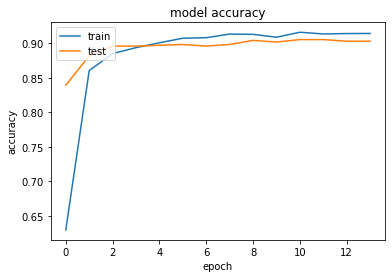

In [8]:
#batch size = 32; learning rate = 1e-5
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2>8) Load saved model</h2>

In [10]:
model = keras.models.load_model('./models/resnet50_top.h5')

<h2>9) Evaluation of the model on data test</h2>

In [11]:
model.evaluate(test_generator)

27/27 [==============================] - 10s 336ms/step - loss: 0.2104 - accuracy: 0.9153


[0.21036697924137115, 0.9152941107749939]